In [11]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
#from tqdm.notebook import tqdm
from tqdm import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [12]:
data = []

for root, subdirs, files in os.walk('dataset/data'): #changed path
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))




100%|██████████| 1/1 [00:00<00:00, 10205.12it/s]






100%|██████████| 160/160 [00:00<00:00, 1255.31it/s]



100%|██████████| 160/160 [00:00<00:00, 1727.47it/s]



100%|██████████| 160/160 [00:00<00:00, 2113.86it/s]



100%|██████████| 160/160 [00:00<00:00, 1963.21it/s]






100%|██████████| 160/160 [00:00<00:00, 1411.62it/s]



100%|██████████| 160/160 [00:00<00:00, 1933.58it/s]



100%|██████████| 160/160 [00:00<00:00, 1777.09it/s]



100%|██████████| 160/160 [00:00<00:00, 1980.15it/s]



100%|██████████| 160/160 [00:00<00:00, 2264.26it/s]



100%|██████████| 160/160 [00:00<00:00, 1682.93it/s]



100%|██████████| 160/160 [00:00<00:00, 1683.43it/s]



100%|██████████| 160/160 [00:00<00:00, 2012.35it/s]



100%|██████████| 160/160 [00:00<00:00, 2059.57it/s]



100%|██████████| 160/160 [00:00<00:00, 1983.05it/s]



100%|██████████| 160/160 [00:00<00:00, 1956.93it/s]



100%|██████████| 160/160 [00:00<00:00, 2061.40it/s]



100%|██████████| 160/160 [00:00<00:00, 1696.31it/s]



100%

In [13]:
print(data[0])

('delete_mark', array([[-0.59194871, -2.0564185 ],
       [-1.10749981, -1.72358499],
       [-0.73167789, -1.57949298],
       [-0.78982185, -1.33604894],
       [-0.63813219, -1.19769015],
       [-0.61820291, -0.97538177],
       [-0.44748775, -0.81930244],
       [-0.33869274, -0.63089084],
       [-0.18408279, -0.44177709],
       [-0.04503403, -0.26699279],
       [ 0.13402561, -0.11031941],
       [ 0.31877319,  0.0414887 ],
       [ 0.51111755,  0.15913344],
       [ 0.69051573,  0.26020367],
       [ 0.8638507 ,  0.36411051],
       [ 1.04083879,  0.43493292],
       [ 1.23708325,  0.61934448],
       [ 1.41892455,  0.73421804],
       [ 1.59796671,  0.81434867],
       [ 1.83782307,  0.90144771],
       [ 1.82299607,  0.96430651],
       [ 1.58686263,  0.99273416],
       [ 1.40841071,  0.99361867],
       [ 1.19702547,  1.0171165 ],
       [ 0.99961903,  1.02758324],
       [ 0.77968464,  1.03353725],
       [ 0.43026292,  1.07362357],
       [ 0.06962748,  1.12189154],
    

## Let's have a look at our data

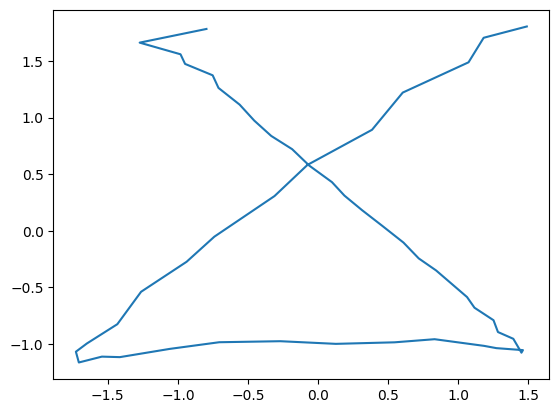

In [17]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [25]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

{'question_mark', 'caret', 'right_sq_bracket', 'x', 'circle', 'v', 'pigtail', 'delete_mark', 'right_curly_brace', 'arrow', 'check', 'left_curly_brace', 'left_sq_bracket', 'triangle', 'rectangle', 'star'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16
(4224, 50, 2) (1056, 50, 2) (4224, 16) (1056, 16)


In [35]:
# Define the model
model = Sequential()

# add LSTM layer
# input shape is (length of an individual sample, dimensions of the sample)
# in our case: two dimensions, as we have X and Y coordinates

# old syntax
#model.add(LSTM(64, input_shape=(NUM_POINTS, 2)))

# new syntax
model.add(Input((NUM_POINTS, 2)))
#model.add(LSTM(64))
#model.add(LSTM(32))
model.add(LSTM(16)) #reduce neurons here

# add dense layer to do machine learning magic
model.add(Dense(32, activation='relu'))

# here, you can add more layers and maybe a dropout for better performance

# softmax layer for classification
model.add(Dense(len(set(labels)), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [36]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1550 - loss: 2.5957 - val_accuracy: 0.4697 - val_loss: 1.6733 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6266 - loss: 1.3830 - val_accuracy: 0.8011 - val_loss: 0.7866 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8464 - loss: 0.6532 - val_accuracy: 0.8513 - val_loss: 0.4494 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8885 - loss: 0.3770 - val_accuracy: 0.9176 - val_loss: 0.2784 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9428 - loss: 0.2358 - val_accuracy: 0.9602 - val_loss: 0.1789 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9583 - loss: 0.1621 - val_accuracy: 0.9669 - val_loss: 0.1362 - learning_rate: 0.0010
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9744 - loss: 0.1090 - 

In [37]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 16)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,866 (26.82 KB)

 Trainable params: 2,288 (8.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,578 (17.89 KB)

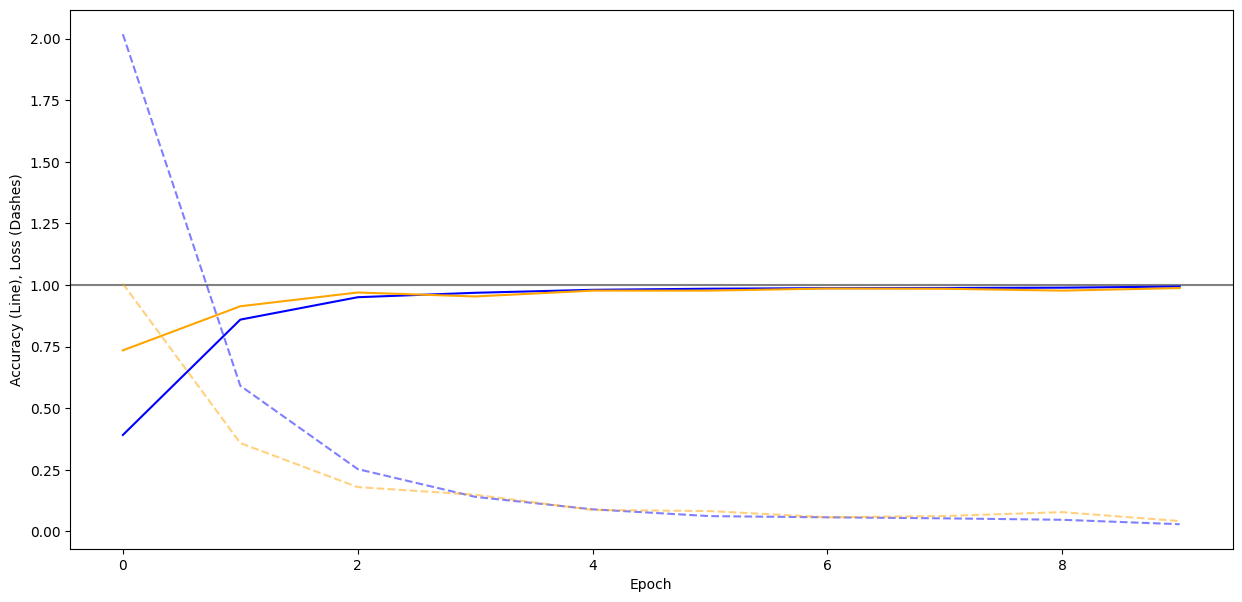

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


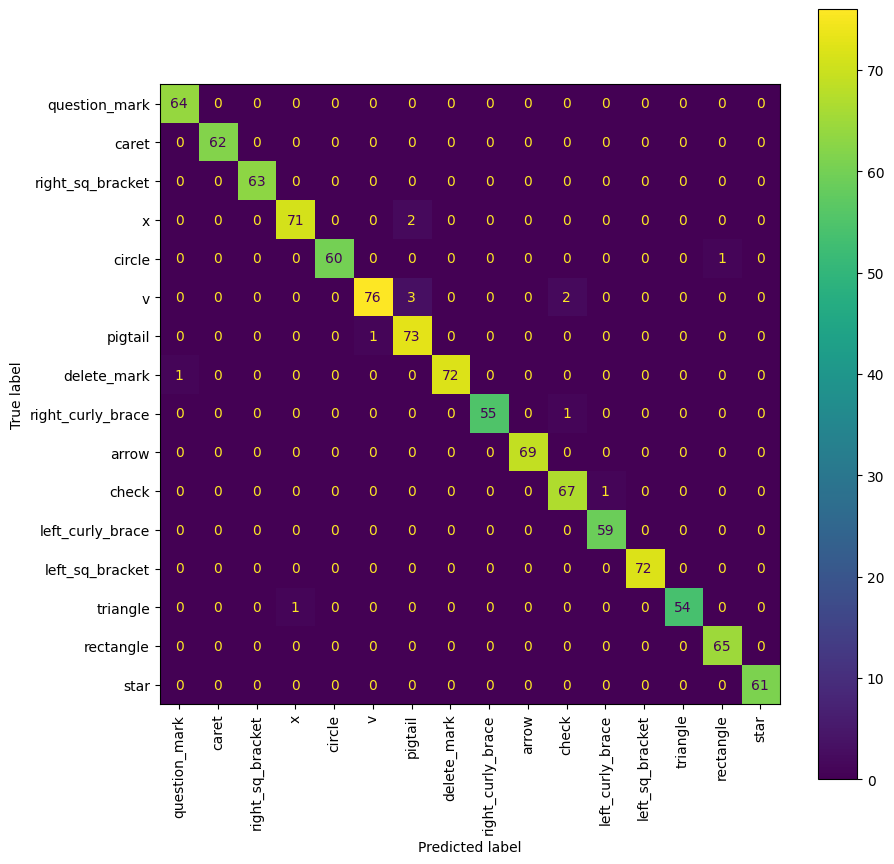

In [32]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

y_test_labels = np.argmax(y_test, axis=1)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=set(labels)).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Label:      right_sq_bracket
Prediction: right_sq_bracket


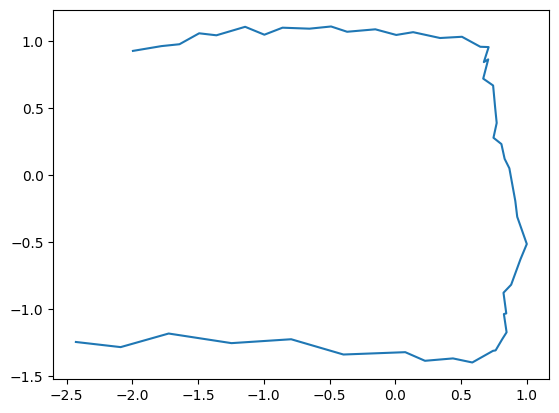

In [33]:
# lets test the model in action

test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

prediction = model.predict(np.array([sequence]))
prediction = np.argmax(prediction)

prediction_label = encoder.inverse_transform(np.array([prediction]))[0]

print('Label:     ', label)
print('Prediction:', prediction_label)